In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from mpl_toolkits.basemap import Basemap, cm
import pyowm
import time
from geopy.distance import geodesic
from math import sqrt

#Define a distance
def sq_distance(lon1, lat1, lon2, lat2):
    d = (lon2-lon1)**2 + (lat2-lat1)**2
    #d = geodesic((lat1, lon1), (lat2, lon2)).km
    return d
    
#Nearest neighbor with plane euclidian distance
def NNI_temp(xlon, xlat, ylon, ylat, temp, prediction):
    nx = prediction.shape[0]
    ny = prediction.shape[1]
    for i_x in range(0, nx):
        if i_x % 50 == 0:
            print('i_x = %d' % i_x)
        for i_y in range(0, ny):
            distance_to_closest = 0
            idx_closest = -1
            distance = 0
            for it in range(0, len(xlon)):
                distance = sq_distance(ylon[i_x][i_y], ylat[i_x][i_y], xlon[it], xlat[it])
                if (idx_closest < 0):
                    distance_to_closest = distance
                    idx_closest = it
                elif (distance_to_closest > distance):
                    distance_to_closest = distance
                    idx_closest = it
            prediction[i_x][i_y] = temp[idx_closest]
            

            
#Inverse distance weighting
#Param: radius of the IDW, if no points in the radius -> NNI 
def IDW_temp(xlon, xlat, ylon, ylat, temp, prediction, radius):
    nx = prediction.shape[0]
    ny = prediction.shape[1]
    for i_x in range(0, nx):
        if i_x % 50 == 0:
            print('i_x = %d' % i_x)
        for i_y in range(0, ny):
            numerator = 0
            denominator = 0
            idx_closest = -1
            distance = 0
            distance_to_closest = 0
            for it in range(0, len(xlon)):
                distance = sqrt(sq_distance(ylon[i_x][i_y], ylat[i_x][i_y], xlon[it], xlat[it]))
                if (idx_closest < 0):
                    distance_to_closest = distance
                    idx_closest = it
                elif (distance_to_closest > distance):
                    distance_to_closest = distance
                    idx_closest = it
                if (distance < radius):
                    numerator += temp[it]/distance
                    denominator += 1/distance
            if (denominator == 0):
                prediction[i_x][i_y] = temp[idx_closest]
            else:
                prediction[i_x][i_y] = numerator/denominator
        

In [2]:
#Read cities list
obs = pd.read_csv("data/Temp-2018_12_21-23_34.csv", ',')
obs = obs.drop(['Unnamed: 0'], axis=1)

In [8]:
#Get cities coordinates and ID
lon = obs['Lon'].tolist()
lat = obs['Lat'].tolist()
ids = obs['ID'].tolist()
temps = obs['Temp'].tolist()

i_x = 0
i_x = 50


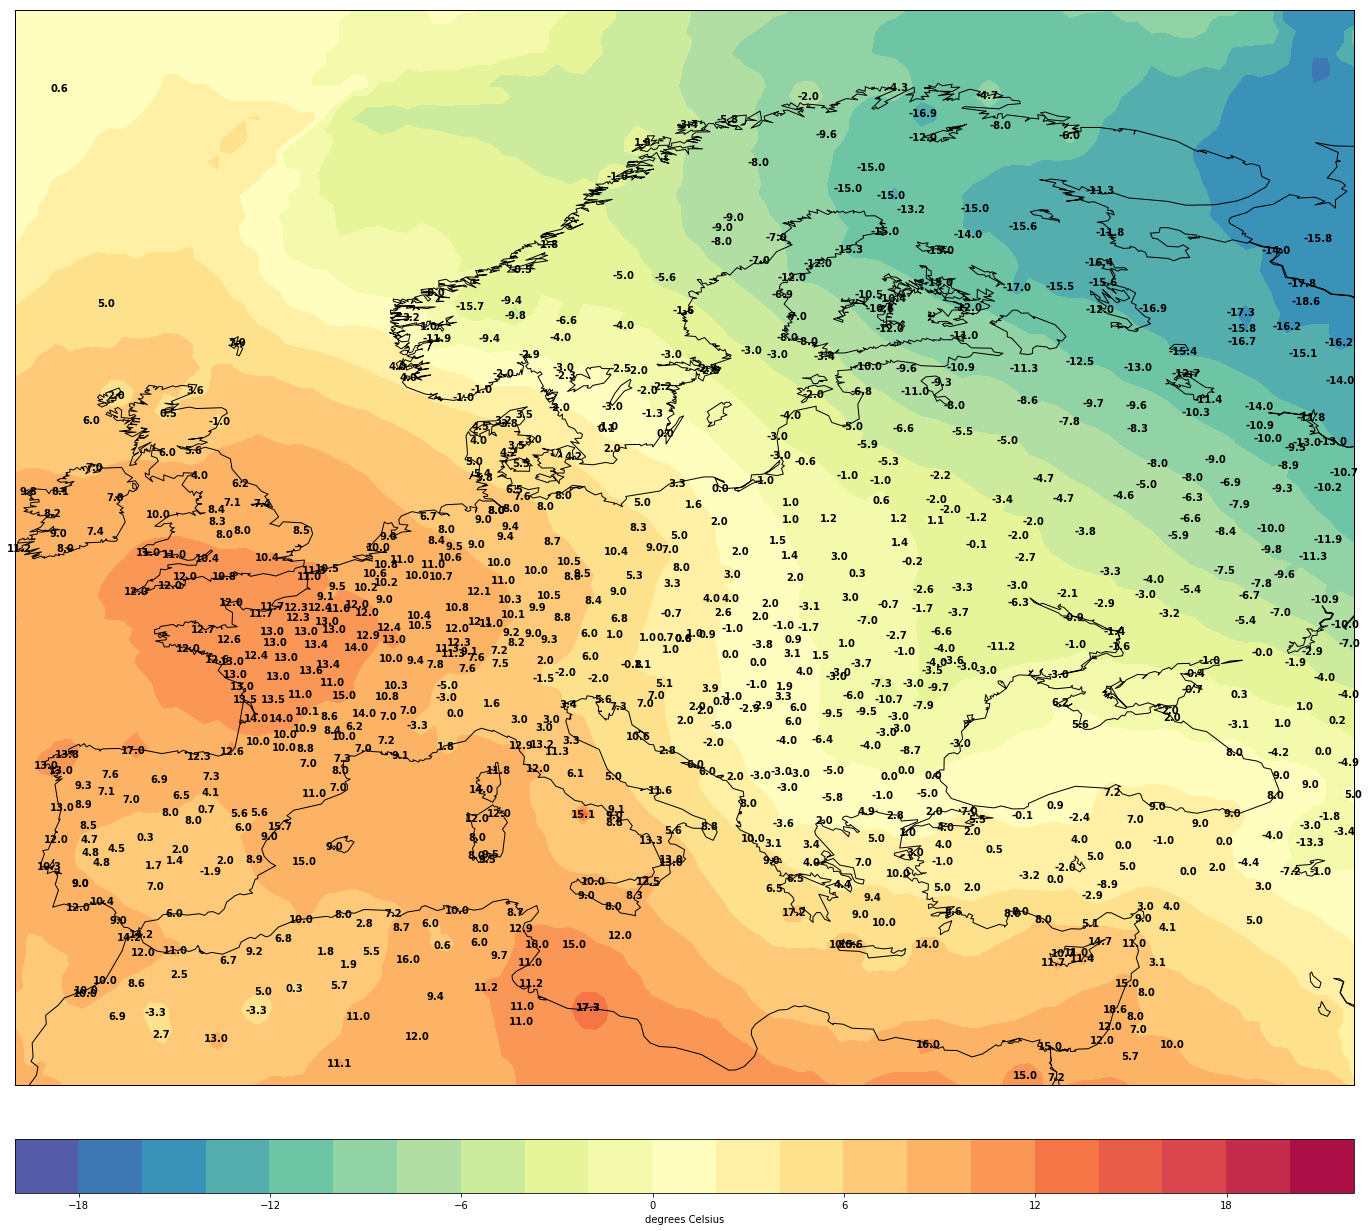

In [20]:
#Map boundaries
lon_min = -10.56
lat_min = 29.65
lon_max = 44.88
lat_max = 74.17

#Interpolation resolution
nx = 100
ny = 100

x_in_bounds = []
y_in_bounds = []
temps_in_bounds = []

#Create map
plt.figure(figsize=(24,24))
map = Basemap(llcrnrlon=lon_min,llcrnrlat=lat_min,urcrnrlon=lon_max,urcrnrlat=lat_max, resolution = 'l', epsg=4668)
map.drawmapboundary(fill_color='white')
#map.fillcontinents(color='coral',lake_color='white')
map.drawcoastlines()

x, y = map(lon, lat)

#Create annotations for temperature and only keep cities in bound
for i in range(0,len(x)-1):
    if lon[i] > lon_min and lon[i] < lon_max and lat[i] > lat_min and lat[i] < lat_max:
        plt.text(x[i], y[i], "{0:.1f}".format(temps[i]),fontsize=10,fontweight='bold', ha='center',va='center',color='k')
        x_in_bounds.append(x[i])
        y_in_bounds.append(y[i])
        temps_in_bounds.append(temps[i])

glons, glats = map.makegrid(nx, ny)
gx, gy = map(glons, glats)
predict = np.zeros((nx, ny))

#Interpolation
#NNI_temp(lon, lat, glons, glats, temps, predict)
IDW_temp(lon, lat, glons, glats, temps, predict, 10)

#Plot contours
clevs = [-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18,20,22]
cs = map.contourf(gx,gy,predict,clevs,cmap='Spectral_r')

#Display colorbar
cbar = map.colorbar(cs,location='bottom',pad="5%")
cbar.set_label('degrees Celsius')